# Analyze System
The purpose of this notebook is to analyze the .csv files (results, data) created from predictsystem.ipynb, and generate candidates for full long Nbody simulations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import rebound
%matplotlib inline

In [2]:
path = '/mnt/raid-cita/asilburt/stability_predict/'
system = "KOI-2086"    #KOI-0156, KOI-0168, KOI-2086, Kepler-431
suffix = ''
columns = ["name","id","shadow","maxorbs","P1","time","dE","elapsed_time"]
Nbody = pd.read_csv(path+"systems/%s_Nbodyresults%s.csv"%(system,suffix),names=columns)

In [3]:
Nbody['time'].max()/3600/2 # includes shadow systems, so only calc time for non shadow

17056.180555555555

## Plot Stability Predictions
These are not Nbody results, these are predictions!

In [4]:
aripath = '/mnt/raid-cita/asilburt/stability_predict/simulation_archives/KOI-2086_2/'

In [5]:
import os
Nsims = 500
sims = []
tfinals = np.zeros(Nsims)
for i in range(Nsims):
    filename = os.path.join(aripath, "KOI-2086_1e9orbits_id{0}_shadow0_SA.bin".format(i))
    try:
        sa = rebound.SimulationArchive(filename)
        P1 = sa[0].particles[1].P
        tfinals[i] = sa[-1].t/P1
        sims.append(sa[0])
    except:
        sims.append(np.nan)

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/rebound/simulationarchive.py:83: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/rebound/simulationarchive.py:127: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/rebound/simulationarchive.py:127: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [6]:
stablemask = tfinals > 9.99e8
stablemask.sum()

0

In [5]:
unstablemask = tfinals < 9.99e8
unstablemask.sum()

24

In [6]:
Nout = len(sims)
h = np.zeros(Nout)
k = np.zeros(Nout)
for i, sim in enumerate(sims):
    try:
        p2 = sim.particles[2]
        h[i] = p2.e*np.sin(p2.pomega)
        k[i] = p2.e*np.cos(p2.pomega)
    except:
        h[i] = np.nan
        k[i] = np.nan

In [7]:
import dill
modelpath = '/mnt/raid-cita/dtamayo/MLstability/Analysis/newmodels/'
model, features, feature_function = dill.load(open(modelpath+"oldmodel.pkl", 'rb'))

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
%%time
proba = [model.predict_proba(feature_function(sim)[features])[0][1] if sim is not np.nan else np.nan for sim in sims]

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


CPU times: user 2min 38s, sys: 0 ns, total: 2min 38s
Wall time: 2min 35s


In [12]:
proba = np.array(proba)
pstablemask = proba > 0.5
pstablemask.sum()

3

In [13]:
punstablemask = (proba <= 0.5)
punstablemask.sum()

497

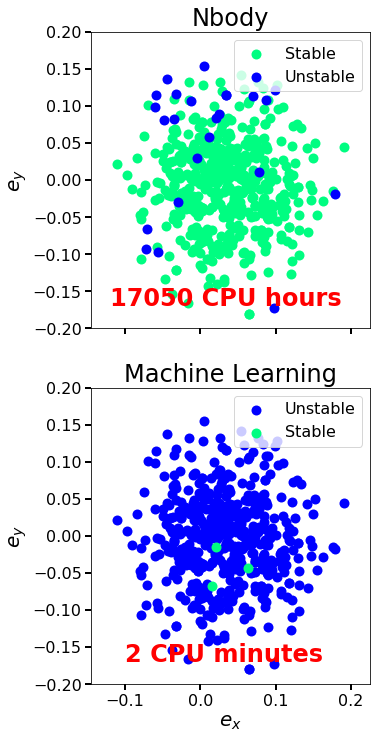

In [17]:
import matplotlib
plt.style.use('paper')
colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
f, (ax1, ax2) = plt.subplots(2,1, figsize=[5, 12], sharex=True, sharey=True)
ax1.scatter(h[stablemask], k[stablemask], c=cmap(0.99), lw=0, label='Stable')
ax1.scatter(h[unstablemask], k[unstablemask], c=cmap(0.), lw=0, label='Unstable')
ax2.scatter(h[punstablemask], k[punstablemask], c=cmap(0.), lw=0, label='Unstable')
ax2.scatter(h[pstablemask], k[pstablemask], c=cmap(0.99), lw=0, label='Stable')


ax1.set_ylim([-0.2, 0.2])
ax1.set_ylabel(r'$e_y$') 
ax2.set_xlabel(r'$e_x$')
ax2.set_ylabel(r'$e_y$')
ax1.set_title("Nbody")
ax2.set_title("Machine Learning")

ax1.text(-0.12, -0.17, '17050 CPU hours', weight='bold', size=24, color='red')
ax2.text(-0.1, -0.17, '2 CPU minutes', weight='bold', size=24, color='red')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.savefig("NbodyvsML.png", bbox_inches="tight")

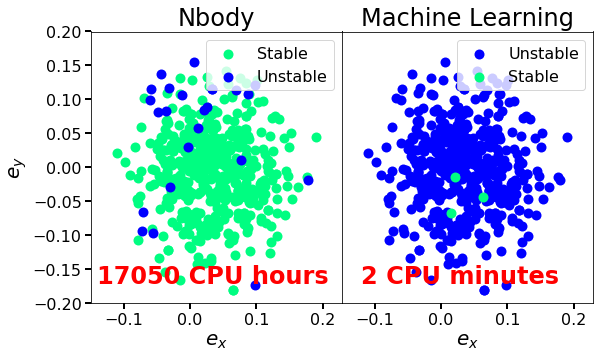

In [18]:
import matplotlib
plt.style.use('paper')
colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
f, (ax1, ax2) = plt.subplots(1,2, figsize=[9, 5], sharex=True, sharey=True)
ax1.scatter(h[stablemask], k[stablemask], c=cmap(0.99), lw=0, label='Stable')
ax1.scatter(h[unstablemask], k[unstablemask], c=cmap(0.), lw=0, label='Unstable')
ax2.scatter(h[punstablemask], k[punstablemask], c=cmap(0.), lw=0, label='Unstable')
ax2.scatter(h[pstablemask], k[pstablemask], c=cmap(0.99), lw=0, label='Stable')

ax1.set_ylim([-0.2, 0.2])
ax1.set_ylabel(r'$e_y$') 
ax1.set_xlabel(r'$e_x$')
ax2.set_xlabel(r'$e_x$')
ax1.set_title("Nbody")
ax2.set_title("Machine Learning")

ax1.text(-0.14, -0.17, '17050 CPU hours', weight='bold', size=24, color='red')
ax2.text(-0.12, -0.17, '2 CPU minutes', weight='bold', size=24, color='red')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.subplots_adjust(wspace=0)
ax2.tick_params(axis='y', which='both', left='off', right='off')
plt.savefig("NbodyvsML.png", bbox_inches="tight")

# Lissauer Comparisons

In [59]:
def checkSLstable(sim):
    M = Ms['Kepler-431']
    Mearth = 3.e-6
    dpy = 365.25
    a1 = (sim.P1/dpy)**(2./3.)
    a2 = (sim.P2/dpy)**(2./3.)
    a3 = (sim.P3/dpy)**(2./3.)
    RH1 = ((sim.m1 + sim.m2)*Mearth/(3.*M))**(1./3.)*(a1+a2)/2.
    RH2 = ((sim.m2 + sim.m3)*Mearth/(3.*M))**(1./3.)*(a2+a3)/2.
    beta1 = (a2-a1)/RH1
    beta2 = (a3-a2)/RH2
    b = 1.496
    c = -3.142 # sec 3.1 of Smith & Lissauer for 3 planets
    logt = b*min(beta1, beta2) + c
    return logt > 9.

In [60]:
checkSLstable(newdata.iloc[0])

True

In [61]:
SLstable = [checkSLstable(sim) for i, sim in newdata.iterrows()]

In [63]:
np.array(SLstable).sum()

2895

In [65]:
len(SLstable)

2897

In [68]:
stablemask.sum()

1037

In [69]:
pstablemask.sum()

1082

In [66]:
unstablemask.sum()

413

In [67]:
punstablemask.sum()

367

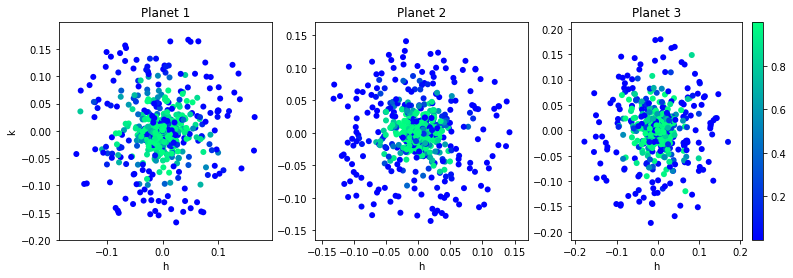

In [4]:
x = "h"
y = "k"
proba = results["predict_proba"].values

colorbar = 'winter'
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4])
ax1.scatter(data["%s1"%x][:len(proba)], data["%s1"%y][:len(proba)], c=proba, cmap=colorbar, lw=0)
ax2.scatter(data["%s2"%x][:len(proba)], data["%s2"%y][:len(proba)], c=proba, cmap=colorbar, lw=0)
c=ax3.scatter(data["%s3"%x][:len(proba)], data["%s3"%y][:len(proba)], c=proba, cmap=colorbar, lw=0)

ax1.set_ylabel(y) 
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax3.set_xlabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
cb = f.colorbar(c)
#plt.savefig("images/%s_%s%s.png"%(system,x,y))

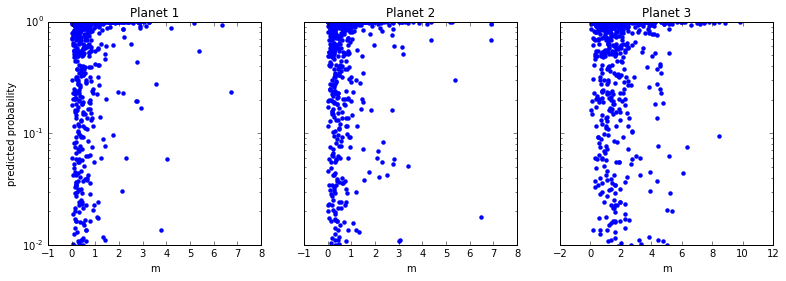

In [13]:
proba = results["predict_proba"].values

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4], sharey=True)
ax1.scatter(data["m1"][:len(proba)], proba, lw=0)
ax2.scatter(data["m2"][:len(proba)], proba, lw=0)
ax3.scatter(data["m3"][:len(proba)], proba, lw=0)

ax1.set_ylabel("predicted probability") 
ax1.set_yscale('log')
ax1.set_ylim([1e-2,1])
ax1.set_xlabel("m")
ax2.set_xlabel("m")
ax3.set_xlabel("m")
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
plt.savefig("images/%s_mproba.png"%system)

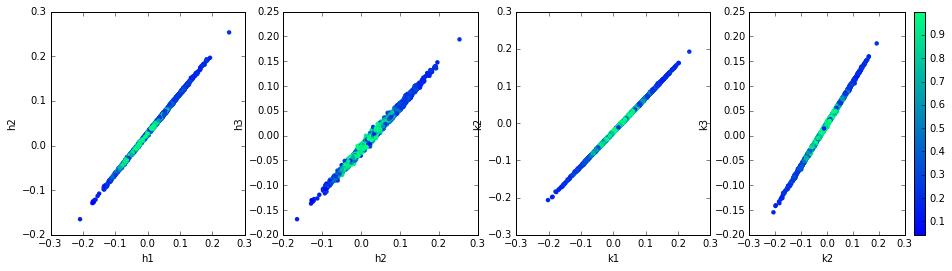

In [8]:
# h of neighboring pairs and k of neighboring pairs
x = "h"
y = "k"
proba = results["predict_proba"].values

colorbar = 'winter'
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[16, 4])
ax1.scatter(data["%s1"%x], data["%s2"%x], c=proba, cmap=colorbar, lw=0)
ax2.scatter(data["%s2"%x], data["%s3"%x], c=proba, cmap=colorbar, lw=0)
ax3.scatter(data["%s1"%y], data["%s2"%y], c=proba, cmap=colorbar, lw=0)
c=ax4.scatter(data["%s2"%y], data["%s3"%y], c=proba, cmap=colorbar, lw=0)

ax1.set_ylabel("%s2"%x) 
ax1.set_xlabel("%s1"%x)
ax2.set_ylabel("%s3"%x)
ax2.set_xlabel("%s2"%x)
ax3.set_ylabel("%s2"%y) 
ax3.set_xlabel("%s1"%y)
ax4.set_ylabel("%s3"%y)
ax4.set_xlabel("%s2"%y)
cb = f.colorbar(c)
plt.savefig("images/%s_%s%s_in_vs_out.png"%(system,x,y))

## Analyze/Plot Results of Nbody Simulations

### Generate new predictions if desired

In [5]:
import pickle
modeldir = 'models/cPickle_No_Lya_Booster_Orb_1000000.pkl'
#modeldir = 'models/OptimalXGBmodel.pkl'
model = pickle.load(open(modeldir, 'rb'))
#model = cPickle.load(open(modeldir, 'rb'))

KeyError: '\n'

In [19]:
import time
from generatefeatures import generate_features
import pickle
def predict_system(system,data,Ms,modeldir,epoch=0):
    
    # run models
    start = time.time()
    fullfeatures = []
    for index, d in data[0:2].iterrows():
        fullfeatures.append(generate_features(d, Ms, epoch))
        print(index)
    print("Simulations took %f seconds"%(time.time() - start))
    
    model = pickle.load(open(modeldir, 'rb'))
    
    features = []
    features += ['avg_iH1', 'avg_iH2']
    features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
    features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
    features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
    features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
    features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
    features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
    features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
    #features += ['Lyapunov_time']
    
    # compile results - take only the features the model uses
    results = pd.DataFrame(columns=features)
    for i in range(len(fullfeatures)):
        results.loc[i] = fullfeatures[i][features] 
        
    # predict stability 
    return model.predict_proba(results)[:,1]

In [23]:
modeldir = "models/No_Lya_Model_Orb_100000.pkl"   #pre-trained machine learning model
#model = 'models/OptimalXGBmodel.pkl'

#run
predict_proba = predict_system(system,data,Ms[system],modeldir)
print predict_proba
#results['predict_proba'] = predict_proba

0
1
Simulations took 1.360531 seconds


KeyError: '\n'

### Separate real/shadow systems

In [35]:
results.head()

,Unnamed: 0,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,...,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a1_slope,norm_a2_slope,norm_a3_slope,Lyapunov_time,predict_proba
0,0,0.0,0.0,0.000013,0.000040,0.000017,0.000039,0.000009,0.000031,0.000008,...,0.024294,0.0,0.0,0.005340,0.001523,-2.298472e-12,-4.439341e-13,1.087982e-12,3925.130174,0.999815
1,1,0.0,0.0,0.000007,0.000031,0.000009,0.000014,0.000023,0.000078,0.000018,...,0.011180,0.0,0.0,0.135368,0.131135,-3.182066e-12,6.102025e-12,-6.546894e-13,914.924491,0.989675
2,2,0.0,0.0,0.000014,0.000029,0.000014,0.000027,0.000063,0.000177,0.000060,...,0.464402,0.0,0.0,0.101708,0.000088,-1.207594e-13,5.399066e-12,-1.694417e-12,930.411663,0.017471
3,3,0.0,0.0,0.000304,0.000669,0.000220,0.000350,0.000084,0.000178,0.000061,...,0.084006,0.0,0.0,0.035023,0.000521,-5.260433e-10,1.430345e-10,-1.134995e-12,136.722612,0.153932
4,4,0.0,0.0,0.000032,0.000112,0.000028,0.000051,0.000034,0.000117,0.000049,...,0.179749,0.0,0.0,0.051646,0.000485,-4.415211e-12,8.135975e-12,-4.067736e-12,1574.518221,0.442657


In [36]:
#create shadow0 and shadow1 arrays
shadow0 = Nbody[Nbody["shadow"]==0].copy()
shadow1 = Nbody[Nbody["shadow"]==1].copy()
r0 = results.iloc[shadow0["id"]]
d0 = data.iloc[shadow0["id"]]
r1 = results.iloc[shadow1["id"]]
d1 = data.iloc[shadow1["id"]]
shadow0["orbital_periods"] = shadow0["time"]/(d0["P1"].values*2*np.pi/365)
shadow1["orbital_periods"] = shadow1["time"]/(d1["P1"].values*2*np.pi/365)
shadow0["predict_proba"] = r0["predict_proba"].values
shadow1["predict_proba"] = r1["predict_proba"].values

params = ["h1","k1","h2","k2","h3","k3"]
#add orbital parameters of interest
for p in params:
    shadow0[p] = d0[p].values
    shadow1[p] = d1[p].values
shadow1.head()

,name,id,shadow,maxorbs,P1,time,dE,elapsed_time,orbital_periods,predict_proba,h1,k1,h2,k2,h3,k3
5,Kepler-431_1e9orbits_id75_shadow1,75,1,1.000000e+09,0.117108,6964.164000,5.292666e-07,5.112272,59467.751090,0.000177,0.000102,0.000051,0.001070,-0.001201,-0.154362,0.073185
6,Kepler-431_1e9orbits_id150_shadow1,150,1,1.000000e+09,0.117108,343.505200,4.021618e-06,0.181674,2933.228128,0.000142,-0.121443,0.052433,0.003708,-0.001530,-0.100484,-0.043378
7,Kepler-431_1e9orbits_id165_shadow1,165,1,1.000000e+09,0.117108,3873.684000,1.927371e-05,1.927599,33077.807460,0.000799,-0.066820,-0.124449,0.039291,-0.007210,-0.018985,-0.003200
9,Kepler-431_1e9orbits_id89_shadow1,89,1,1.000000e+09,0.117108,1489.042000,5.662596e-07,0.800456,12715.091003,0.002120,-0.001966,0.003991,-0.010698,0.063158,-0.097548,0.014170
10,Kepler-431_1e9orbits_id12_shadow1,12,1,1.000000e+09,0.117108,1.245422,6.648246e-04,0.019746,10.634793,0.002480,0.050165,-0.141844,0.027664,0.059868,0.000842,0.000704


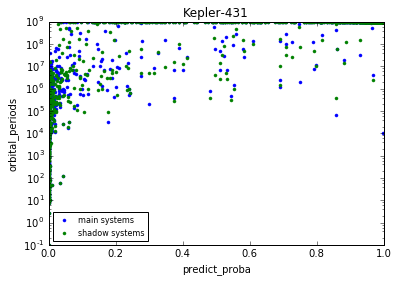

In [37]:
#2D plots
y = "orbital_periods"
x = "predict_proba"

plt.plot(shadow0[x], shadow0[y],'.',label='main systems')
plt.plot(shadow1[x], shadow1[y],'.',label='shadow systems')
plt.xlabel(x)
plt.ylabel(y)
plt.yscale('log')
#plt.xscale('log')
plt.title(system)
plt.legend(loc='lower left',fontsize=8,numpoints=1)
#plt.savefig('images/Nbody-%s_%sv%s.png'%(system,x,y))

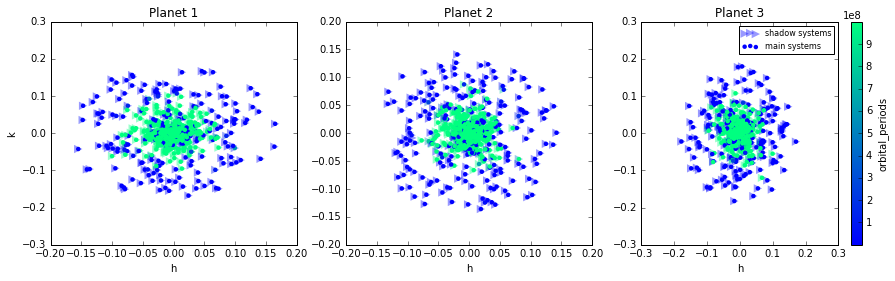

In [38]:
# 3D plots of Nbody results
x = "h"
y = "k"
c = "orbital_periods"

s = 70   #size of markers
m = ">"  #marker for shadow systems
alpha = 0.4 #alpha for shadow systems
colorbar = 'winter'

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15, 4])
ax1.scatter(shadow1["%s1"%x], shadow1["%s1"%y], c=shadow1[c], marker=m, s=s, alpha=alpha, cmap=colorbar, lw=0, label='shadow systems')
ax1.scatter(shadow0["%s1"%x], shadow0["%s1"%y], c=shadow0[c], cmap=colorbar, lw=0,label='main systems')
ax2.scatter(shadow1["%s2"%x], shadow1["%s2"%y], c=shadow1[c], marker=m, s=s, alpha=alpha, cmap=colorbar, lw=0, label='shadow systems')
ax2.scatter(shadow0["%s2"%x], shadow0["%s2"%y], c=shadow0[c], cmap=colorbar, lw=0,label='main systems')
ax3.scatter(shadow1["%s3"%x], shadow1["%s3"%y], c=shadow1[c], marker=m, s=s, alpha=alpha, cmap=colorbar, lw=0, label='shadow systems')
sc=ax3.scatter(shadow0["%s3"%x], shadow0["%s3"%y], c=shadow0[c], cmap=colorbar, lw=0,label='main systems')

ax1.set_ylabel(y) 
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax3.set_xlabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
sc = f.colorbar(sc)
#cb = f.colorbar(sc, cax=cbar_ax)
sc.set_label(label=c, size=10)
plt.legend(fontsize=8, numpoints=1)
#plt.savefig('images/Nbody-%s_%sv%sv%s.png'%(system,x,y,c))

## Analyze Results of particular Simulation Archive Runs

In [9]:
thresh = 1e-4
Nbody.loc[Nbody["dE"]>thresh]

,name,id,shadow,maxorbs,P1,time,dE,elapsed_time
2,KOI-0156_1e9orbits_id773_shadow1,773,1,1.000000e+09,0.089313,54613.69,0.000716,46.44199
55,KOI-0156_1e9orbits_id1896_shadow1,1896,1,1.000000e+09,0.089313,1648814.00,0.000178,1406.74400
67,KOI-0156_1e9orbits_id435_shadow0,435,0,1.000000e+09,0.089308,32179440.00,0.000433,15464.01000
70,KOI-0156_1e9orbits_id216_shadow1,216,1,1.000000e+09,0.089313,15644800.00,0.000620,13415.23000
202,KOI-0156_1e9orbits_id215_shadow0,215,0,1.000000e+09,0.089313,1479310.00,0.000124,1254.37000
344,KOI-0156_1e9orbits_id1973_shadow0,1973,0,1.000000e+09,0.089314,79668210.00,0.000162,70686.07000


In [17]:
#load simulation archive of system with high final energy error
i=2

id_ = Nbody.loc[Nbody["dE"]>thresh,"id"].iloc[i]
shadow = Nbody.loc[Nbody["dE"]>thresh,"shadow"].iloc[i]
orbits = "1e9"
#dir_ = "saved_output/%s_simulation_archives"%system
dir_ = "saved_output"
sa = rebound.SimulationArchive("%s/%s_%sorbits_id%s_shadow%d_SA.bin"%(dir_,system,orbits,id_,shadow))
print("Number of snapshots: %d" % len(sa))
print("Time of first and last snapshot: %.1f, %.1f" % (sa.tmin, sa.tmax))

Number of snapshots: 361
Time of first and last snapshot: 0.0, 32150778.6


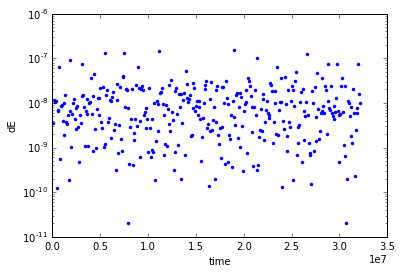

In [18]:
#Get energy at each checkpoint
sim = sa[0]
E0 = sim.calculate_energy()
dE = []
t = []

#get energies at each snapshot
for s in sa:
    dE.append(np.abs((s.calculate_energy() - E0)/E0))
    t.append(s.t)
    
plt.plot(t,dE,'.')
plt.ylabel("dE")
plt.xlabel("time")
plt.yscale('log')

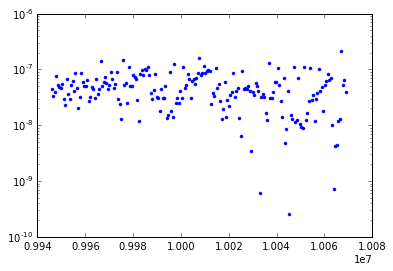

In [34]:
#simulate last few orbits - will take a second
sim = sa[0]
E0 = sim.calculate_energy()
dE = []
t = []

def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0

sim.collision = 'direct'
sim.collision_resolve = collision

s = sa[-1]
dt = sa[-1].t-sa[-2].t
for time in np.linspace(s.t,s.t+dt,200):
    s.integrate(time)
    t.append(s.t)
    dE.append(np.abs((s.calculate_energy() - E0)/E0))
    
plt.plot(t,dE,'.')
plt.yscale('log')

### Plot deviation of various orbital elements from simulation archives
See if orbital elements drift significantly even though it remained "stable" over 1e9 orbits.

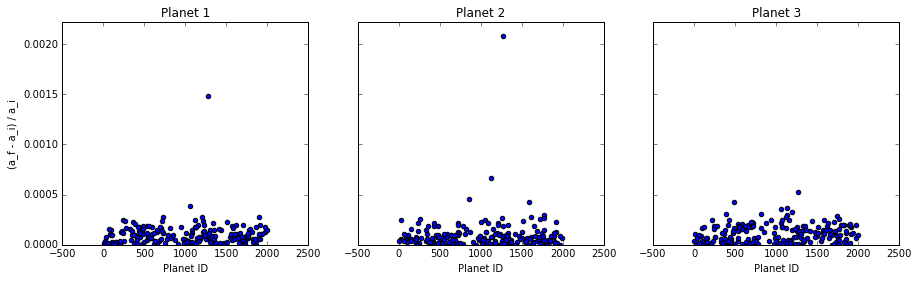

In [26]:
#prepare data
x = "a"     #what orbital element are you plotting?

shadow0 = Nbody[(Nbody["shadow"]==0)].copy()
d0 = data.iloc[shadow0["id"]]
shadow0["orbital_periods"] = shadow0["time"]/(d0["P1"].values*2*np.pi/365)
shadow0 = shadow0[shadow0["orbital_periods"]>9e8]

#get values
orbits = "1e9"
dir_ = "saved_output/%s_simulation_archives"%system
norm = []
for id_ in shadow0["id"]:
    sa = rebound.SimulationArchive("%s/%s_%sorbits_id%s_shadow0_SA.bin"%(dir_,system,orbits,id_))
    x1 = getattr(sa[0].particles[1],x)
    x2 = getattr(sa[0].particles[2],x)
    x3 = getattr(sa[0].particles[3],x)
    norm.append((np.abs(getattr(sa[-1].particles[1],x)-x1)/x1, #final - initial
                 np.abs(getattr(sa[-1].particles[2],x)-x2)/x2,
                 np.abs(getattr(sa[-1].particles[3],x)-x3)/x3))
    
o1, o2, o3 = np.asarray(zip(*norm))
    
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15, 4], sharey=True)
ax1.scatter(shadow0["id"], o1)
ax2.scatter(shadow0["id"], o2)
ax3.scatter(shadow0["id"], o3)
ax1.set_ylim([0,1.5*max(o1)])
ax1.set_xlabel("Planet ID")
ax2.set_xlabel("Planet ID")
ax3.set_xlabel("Planet ID")
ax1.set_ylabel("(%s_f - %s_i) / %s_i"%(x,x,x))
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")

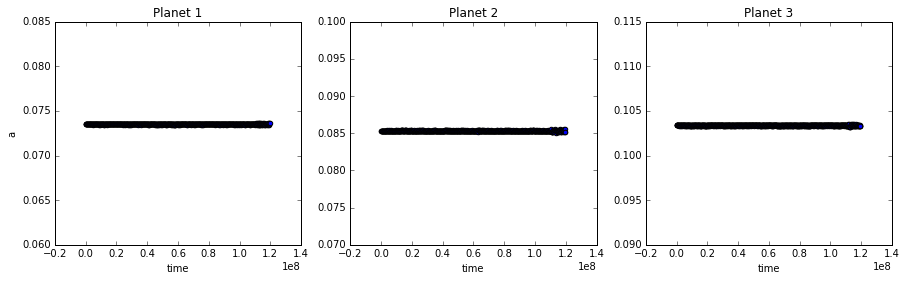

In [27]:
#check out specific system
i=0
ids = shadow0["id"].values
id_ = ids[np.where(o2 > 0.0015)[0][i]]

sa = rebound.SimulationArchive("%s/%s_%sorbits_id%s_shadow0_SA.bin"%(dir_,system,orbits,id_))
t, arr = [], []
for s in sa:
    arr.append((getattr(s.particles[1],x), getattr(s.particles[2],x), getattr(s.particles[3],x)))
    t.append(s.t)
    
a4, a5, a6 = zip(*arr)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15, 4])
ax1.scatter(t, a4)
ax2.scatter(t, a5)
ax3.scatter(t, a6)
ax1.set_xlabel("time")
ax2.set_xlabel("time")
ax3.set_xlabel("time")
ax1.set_ylabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")

# Scratch

In [11]:
#check all sims finished are there...
array = zip(Nbody["id"].values,Nbody["shadow"].values)
for i in np.arange(250,1450):
    if ((i,0) not in array) or ((i,1) not in array):
        print "%d not done"%i

745 not done
1194 not done
1288 not done
1292 not done
